---
author:
  - name: Pietro Rota
    affiliation:
      - name: Bayes business school - City St. George
        city: London
        state: UK
        url: https://www.bayes.citystgeorges.ac.uk/
format:
  html:
    code-tools: true
    code-fold: true
    code-summary: Show code
    html-table-processing: none
    df-print: kable
    code-block-border-left: royalblue
    code-block-bg: true
    toc: true
title: Implied Probability Density Functions
jupyter: python3
---

Le distribuzioni di probabilità della volatilità implicita (IVPD) sono un modo per capire cosa si aspetta il mercato riguardo al futuro prezzo di un asset (come un'azione o un indice) basandosi sui prezzi delle opzioni disponibili. Invece di darti un singolo valore per la volatilità futura, queste distribuzioni ti mostrano la probabilità che l'asset raggiunga diversi prezzi in futuro.
Immagina di lanciare una moneta. Sai che la probabilità di testa o croce è 50/50. Nel mercato, con le opzioni, possiamo "indovinare" le probabilità che il prezzo di un'azione salga, scenda o rimanga stabile, non con la stessa certezza di una moneta, ma con una stima basata su quanto gli investitori sono disposti a pagare per le opzioni.
Come funzionano in breve:
Prezzi delle Opzioni: Ogni opzione ha un prezzo di mercato. Questo prezzo incorpora le aspettative degli operatori sulla volatilità futura dell'asset.
Volatilità Implicita: Dal prezzo di ogni opzione, possiamo calcolare la sua "volatilità implicita". È la volatilità che, se inserita in un modello di pricing delle opzioni (come Black-Scholes), riprodurrebbe il prezzo di mercato osservato.
La "Curva del Sorriso" (Volatility Smile/Skew): Se calcoli la volatilità implicita per opzioni con diverse strike price (prezzi di esercizio) ma stessa scadenza, noterai che non è la stessa per tutte. Spesso assume una forma a "sorriso" o "smorfia", indicando che il mercato si aspetta probabilità diverse per movimenti di prezzo estremi (ad esempio, un crollo del mercato è percepito come più probabile di un rialzo equivalente).
Costruzione della Distribuzione: Utilizzando queste volatilità implicite per l'intera catena di opzioni, si possono costruire delle curve che rappresentano la distribuzione di probabilità neutrale al rischio del prezzo futuro dell'asset. In pratica, queste curve ti dicono quali prezzi futuri sono considerati più probabili dal mercato e quali meno.
Cosa ci dicono?
Forma della Distribuzione: Una distribuzione simmetrica suggerisce che il mercato si aspetta movimenti di prezzo equamente probabili in entrambe le direzioni. Una distribuzione asimmetrica (skewed) indica una maggiore probabilità di movimenti in una direzione (es. più probabile un calo che un rialzo).
"Code Pesanti" (Fat Tails): Se le code della distribuzione sono più "pesanti" del normale, significa che il mercato attribuisce una probabilità maggiore a eventi estremi (grandi rialzi o grandi crolli) rispetto a quanto previsto da un modello standard.
Cambiamenti nel Tempo: Monitorando come queste distribuzioni cambiano prima e dopo eventi importanti (come un annuncio di utili o il lancio di un nuovo prodotto), possiamo capire come le aspettative del mercato si modificano in risposta a nuove informazioni. Ad esempio, un evento incerto potrebbe allargare la distribuzione, indicando maggiore incertezza, o spostare il suo picco, indicando un cambiamento nella direzione attesa del prezzo.
In sintesi, le IVPD sono uno strumento potente per visualizzare e analizzare le aspettative aggregate del mercato riguardo ai futuri movimenti di prezzo e al rischio, derivandole direttamente dai prezzi delle opzioni.


In [67]:
import yfinance as yf
import numpy as np
import pandas as pd
from scipy.stats import norm
from scipy.optimize import brentq
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy.stats import norm
from datetime import datetime
import matplotlib.pyplot as plt


The core concept is based on Breeden and Litzenberger (1978), who showed that the second derivative of a European call price with respect to strike gives the risk-neutral PDF of the underlying asset price at maturity:
$$
f(K)=e^{rT} ⋅ \frac{∂^2C(K)}{∂K^2}​
$$


In [68]:
def black_scholes_price(S, K, T, r, sigma, option_type="call"):
    """Black-Scholes price for call/put"""
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    if option_type == "call":
        return S * norm.cdf(d1) - K * np.exp(-r*T) * norm.cdf(d2)
    else:  # put
        return K * np.exp(-r*T) * norm.cdf(-d2) - S * norm.cdf(-d1)


def implied_volatility(market_price, S, K, T, r, option_type="call"):
    """Solve for IV using Brent root finder"""
    try:
        f = lambda sigma: black_scholes_price(S, K, T, r, sigma, option_type) - market_price
        return brentq(f, 1e-6, 5.0, maxiter=500)
    except:
        return np.nan


def implied_pdf(S, K, T, r, sigma):
    """Breeden-Litzenberger: risk-neutral density via BS second derivative wrt strike"""
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    pdf = (np.exp(-r*T) * norm.pdf(d2)) / (K * sigma * np.sqrt(T))
    return pdf


In [69]:
def calculate_probability_distribution(strike, spot, iv, days_to_exp, risk_free_rate = r):
    """
    Calculate the implied probability distribution from Black-Scholes
    Returns price range and probability density
    """
    T = days_to_exp / 365.0
    
    if T <= 0 or iv <= 0:
        return None, None
    
    # Generate price range (±4 standard deviations)
    std_dev = spot * iv * np.sqrt(T)
    price_range = np.linspace(max(spot - 4*std_dev, 0.01), spot + 4*std_dev, 200)
    
    # Calculate log-normal distribution parameters
    mu = np.log(spot) + (risk_free_rate - 0.5 * iv**2) * T
    sigma = iv * np.sqrt(T)
    
    # Probability density function
    pdf = (1 / (price_range * sigma * np.sqrt(2 * np.pi))) * \
          np.exp(-0.5 * ((np.log(price_range) - mu) / sigma)**2)
    
    return price_range, pdf

def get_option_chain_data(ticker_symbol):
    """
    Fetch complete option chain data for all expirations
    """
    ticker = yf.Ticker(ticker_symbol)
    current_price = ticker.history(period='1d')['Close'].iloc[-1]
    
    expirations = ticker.options
    
    all_options = []
    
    for exp_date in expirations:
        opt_chain = ticker.option_chain(exp_date)
        
        # Process calls
        calls = opt_chain.calls.copy()
        calls['type'] = 'call'
        calls['expiration'] = exp_date
        
        # Process puts
        puts = opt_chain.puts.copy()
        puts['type'] = 'put'
        puts['expiration'] = exp_date
        
        all_options.append(pd.concat([calls, puts]))
    
    options_df = pd.concat(all_options, ignore_index=True)
    
    # Calculate days to expiration
    options_df['expiration'] = pd.to_datetime(options_df['expiration'])
    options_df['days_to_exp'] = (options_df['expiration'] - datetime.now()).dt.days
    
    # Filter out options with missing IV
    options_df = options_df[options_df['impliedVolatility'].notna()]
    options_df = options_df[options_df['impliedVolatility'] > 0]
    
    return options_df, current_price

def create_3d_ipdf_surface(options_df, current_price):
    """
    Create 3D surface plot showing how IPDF changes across strikes and expirations
    """
    # Group by expiration
    expirations = sorted(options_df['expiration'].unique())
    
    # Prepare data for surface plot
    price_ranges = []
    pdfs_matrix = []
    exp_labels = []
    
    for exp in expirations[:8]:  # Limit to first 8 expirations for clarity
        exp_data = options_df[options_df['expiration'] == exp]
        days_to_exp = exp_data['days_to_exp'].iloc[0]
        
        # Use ATM option IV as reference
        atm_option = exp_data.iloc[(exp_data['strike'] - current_price).abs().argsort()[:1]]
        if len(atm_option) > 0:
            iv = atm_option['impliedVolatility'].iloc[0]
            
            price_range, pdf = calculate_probability_distribution(
                current_price, current_price, iv, days_to_exp
            )
            
            if price_range is not None:
                price_ranges.append(price_range)
                pdfs_matrix.append(pdf)
                exp_labels.append(f"{exp.strftime('%Y-%m-%d')} ({days_to_exp}d)")
    
    # Create meshgrid for 3D plot
    if len(price_ranges) > 0:
        fig = go.Figure(data=[go.Surface(
            x=price_ranges[0],
            y=list(range(len(exp_labels))),
            z=pdfs_matrix,
            colorscale='Viridis',
            opacity=0.8,
            name='Probability Density'
        )])
        
        fig.update_layout(
            title=f'3D Implied Probability Distribution - Full Option Chain looking at {TICKER}',
            scene=dict(
                xaxis_title='Stock Price',
                yaxis=dict(
                    title='Expiration',
                    ticktext=exp_labels,
                    tickvals=list(range(len(exp_labels)))
                ),
                zaxis_title='Probability Density',
                camera=dict(eye=dict(x=1.5, y=1.5, z=1.3))
            ),
            height=700
        )
        
        return fig
    return None

def create_ipdf_overlay(options_df, current_price):
    """
    Create 2D plot with multiple IPDFs overlaid with alpha transparency
    """
    fig, ax = plt.subplots(figsize=(12, 7))
    
    expirations = sorted(options_df['expiration'].unique())
    
    colors = plt.cm.tab10(np.linspace(0, 1, 10))
    
    for idx, exp in enumerate(expirations[:8]):
        exp_data = options_df[options_df['expiration'] == exp]
        days_to_exp = exp_data['days_to_exp'].iloc[0]
        
        # Use ATM option IV
        atm_option = exp_data.iloc[(exp_data['strike'] - current_price).abs().argsort()[:1]]
        if len(atm_option) > 0:
            iv = atm_option['impliedVolatility'].iloc[0]
            
            price_range, pdf = calculate_probability_distribution(
                current_price, current_price, iv, days_to_exp
            )
            
            if price_range is not None:
                ax.plot(price_range, pdf, 
                       label=f"{exp.strftime('%Y-%m-%d')} ({days_to_exp}d)",
                       color=colors[idx % len(colors)], linewidth=2)
                ax.fill_between(price_range, pdf, alpha=0.3, color=colors[idx % len(colors)])
    
    # Add vertical line for current price
    ax.axvline(x=current_price, linestyle='--', color='red', linewidth=2,
               label=f'Current: ${current_price:.2f}')
    
    ax.set_title(f'Implied Probability Distribution Functions - Overlay View looking at {TICKER}', fontsize=14, fontweight='bold')
    ax.set_xlabel('Stock Price', fontsize=12)
    ax.set_ylabel('Probability Density', fontsize=12)
    ax.legend(loc='upper right', fontsize=9)
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    
    return fig

def create_mode_and_quartiles(options_df, current_price):
    """
    Create chart showing most probable value (mode) and confidence intervals
    """
    expirations = sorted(options_df['expiration'].unique())
    
    exp_labels = []
    modes = []
    q25 = []
    q75 = []
    q5 = []
    q95 = []
    days_list = []
    
    for exp in expirations[:12]:
        exp_data = options_df[options_df['expiration'] == exp]
        days_to_exp = exp_data['days_to_exp'].iloc[0]
        
        atm_option = exp_data.iloc[(exp_data['strike'] - current_price).abs().argsort()[:1]]
        if len(atm_option) > 0:
            iv = atm_option['impliedVolatility'].iloc[0]
            T = days_to_exp / 365.0
            
            # Mode of lognormal distribution
            mode = current_price * np.exp(-iv**2 * T)
            
            # Calculate quantiles using lognormal distribution
            mu = np.log(current_price) + (0.05 - 0.5 * iv**2) * T
            sigma = iv * np.sqrt(T)
            
            q5_val = np.exp(mu + sigma * norm.ppf(0.05))
            q25_val = np.exp(mu + sigma * norm.ppf(0.25))
            q75_val = np.exp(mu + sigma * norm.ppf(0.75))
            q95_val = np.exp(mu + sigma * norm.ppf(0.95))
            
            exp_labels.append(f"{exp.strftime('%m/%d')}")
            modes.append(mode)
            q25.append(q25_val)
            q75.append(q75_val)
            q5.append(q5_val)
            q95.append(q95_val)
            days_list.append(days_to_exp)
    
    fig, ax = plt.subplots(figsize=(12, 7))
    
    x_pos = np.arange(len(exp_labels))
    
    # 90% confidence interval
    ax.fill_between(x_pos, q5, q95, alpha=0.3, color='lightblue', label='90% CI (5th-95th)')
    
    # 50% confidence interval (IQR)
    ax.fill_between(x_pos, q25, q75, alpha=0.5, color='blue', label='50% CI (25th-75th)')
    
    # Mode (most probable value)
    ax.plot(x_pos, modes, 'o-', color='darkgreen', linewidth=3, 
            markersize=8, label='Most Probable (Mode)')
    
    # Current price line
    ax.axhline(y=current_price, linestyle='--', color='red', linewidth=2,
               label=f'Current: ${current_price:.2f}')
    
    ax.set_title(f'Most Probable Value and Confidence Intervals by Expiration looking at {TICKER}', 
                 fontsize=14, fontweight='bold')
    ax.set_xlabel('Expiration Date', fontsize=12)
    ax.set_ylabel('Stock Price', fontsize=12)
    ax.set_xticks(x_pos)
    ax.set_xticklabels(exp_labels, rotation=45, ha='right')
    ax.legend(loc='best', fontsize=10)
    ax.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    
    return fig


In [70]:
# Set ticker symbol
TICKER = "SPY"  # Change this to any ticker
interest = yf.Ticker("^IRX")
r = interest.history(period="1d")["Close"].iloc[-1]/100  # assume risk-free rate ~5% (you could pull ^IRX)

print(f"Fetching option chain data for {TICKER}...")
options_df, current_price = get_option_chain_data(TICKER)

print(f"Current price: ${current_price:.2f}")
print(f"Total options loaded: {len(options_df)}")
print(f"Expirations available: {len(options_df['expiration'].unique())}")


Fetching option chain data for SPY...
Current price: $663.68
Total options loaded: 8161
Expirations available: 31


In [71]:

# Create visualizations
print("\nGenerating 3D IPDF surface plot...")
fig_3d = create_3d_ipdf_surface(options_df, current_price)
fig_3d.show()



Generating 3D IPDF surface plot...


Generating IPDF overlay plot...


<positron-console-cell-72>:3: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



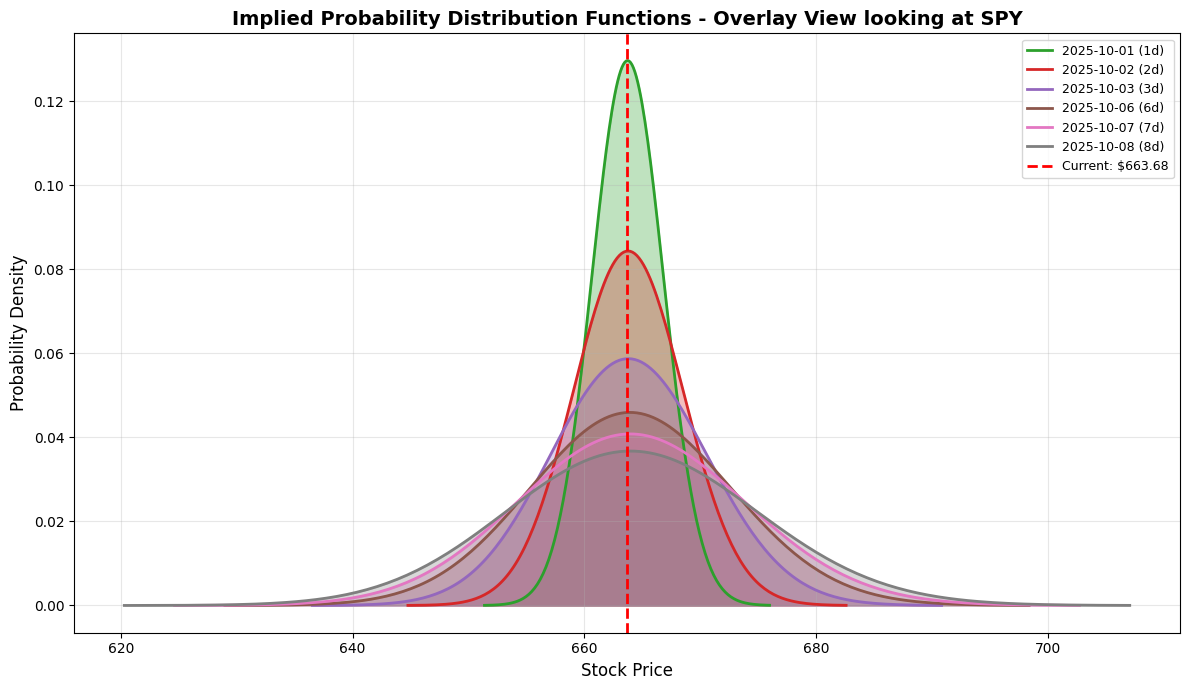

In [72]:

print("Generating IPDF overlay plot...")
fig_overlay = create_ipdf_overlay(options_df, current_price)
fig_overlay.show()


Generating mode and quartiles plot...


<positron-console-cell-73>:192: RuntimeWarning:

invalid value encountered in sqrt

<positron-console-cell-73>:3: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



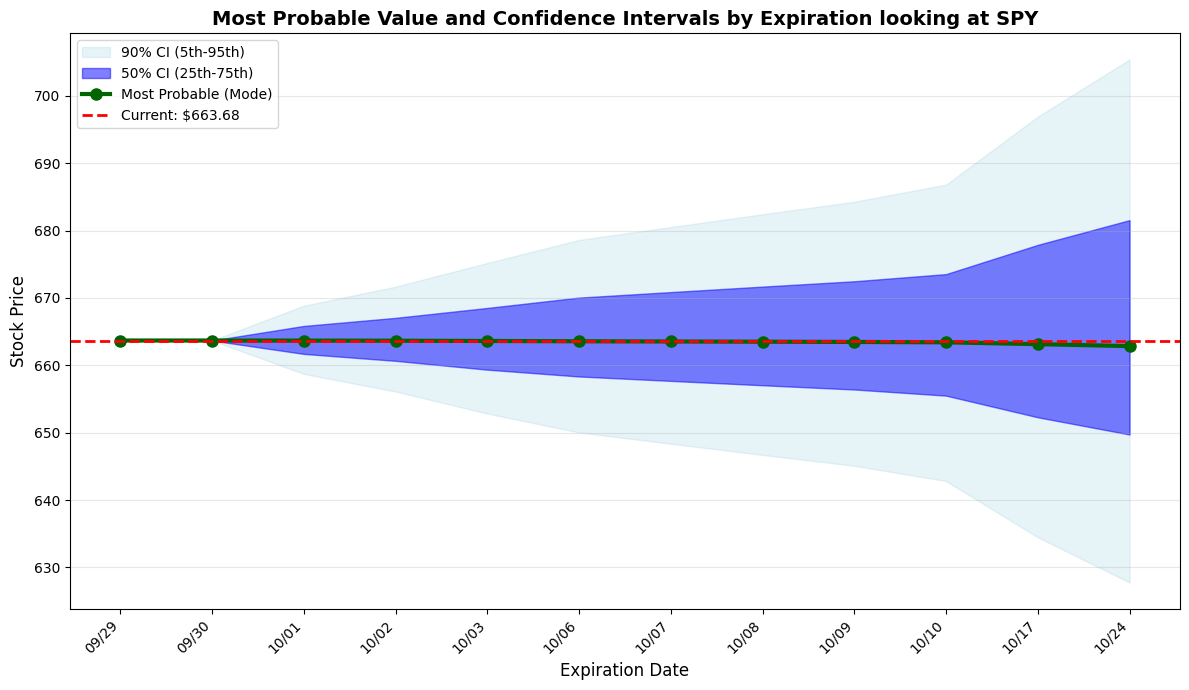

In [73]:

print("Generating mode and quartiles plot...")
fig_quartiles = create_mode_and_quartiles(options_df, current_price)
fig_quartiles.show()


In [74]:
print("hj",ticker)


hj SPY
